# GANs - MNIST

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('TensorFlow Version: {}'.format(tf.__version__))

/device:GPU:0
TensorFlow Version: 1.10.0


In [0]:
# A bunch of utility functions

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


def show_images(images, img_rows=28, img_cols=28):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(img_rows, img_cols))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

## Downloading dataset

In [3]:
from keras.datasets import mnist
from keras import backend as K
from keras.utils import to_categorical

# the data, shuffled and split between train and test sets
(x_train, _), (_, _) = mnist.load_data()

Using TensorFlow backend.


In [0]:
img_rows, img_cols = 28, 28
num_classes = 10

In [11]:
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)

x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))

x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
x_train /= 255.
# x_test /= 255.
print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# y_train = to_categorical(y_train, num_classes)
# y_test = to_categorical(y_test, num_classes)

x_train shape: (60000, 784)


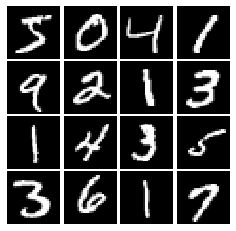

In [6]:
# show sample images
show_images(x_train[:16])

## Main

In [0]:
class dataset_batches():
    def __init__(self, x_train, shuffle=True):
        self.shuffle = shuffle
        self.x_train = x_train
        
    def batches(self, batch_size):
        n = len(self.x_train)
        if self.shuffle:
            idx = np.arange(n)
            np.random.shuffle(idx)
            self.x_train = self.x_train[idx]
            
        n_batches = n // batch_size
        for i in range(0, n, batch_size):
            yield self.x_train[i:i+batch_size]

In [0]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(alpha*x, x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform((batch_size, dim), minval=-1, maxval=1)

# a giant helper function
def run_a_gan(sess, x_train,
              G_train_step, G_loss, D_train_step, D_loss,
              G_extra_step, D_extra_step,
              show_every=250, print_every=50, batch_size=128, epochs=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    it = 0
    for epoch in range(epochs):
        for minibatch in dataset_batches(x_train).batches(batch_size):
            
            # every show often, show a sample result
            if it % show_every == 0:
                samples = sess.run(G_sample)
                fig = show_images(samples[:16])
                plt.show()
            
            # run a batch of data through the network
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            _, G_loss_curr = sess.run([G_train_step, G_loss])

            # print loss every so often.
            # We want to make sure D_loss doesn't go to 0
            if it % print_every == 0:
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(it, D_loss_curr, G_loss_curr))
                
            it += 1

    print('Final images')
    samples = sess.run(G_sample)
    fig = show_images(samples[:16])
    plt.show()

In [0]:
def discriminator(x):
    with tf.variable_scope('discriminator'):
        x_img = tf.reshape(x, [-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_img, 64, 4, strides=2, activation=leaky_relu, padding='valid')
        conv2 = tf.layers.conv2d(conv1, 128, 4, strides=2, activation=leaky_relu, padding='valid')
        bn1 = tf.layers.batch_normalization(conv2, training=True)
        dims = int(np.prod(bn1.get_shape()[1:]))
        bn1_flat = tf.reshape(bn1, [-1,dims])
        fc1 = tf.layers.dense(bn1_flat, 1024, activation=leaky_relu)
        logits = tf.layers.dense(fc1, 1)
        return logits

def generator(z):
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        bn2_img = tf.reshape(bn2, [-1, 7, 7, 128])
        convT1 = tf.layers.conv2d_transpose(bn2_img, 64, 4, strides=2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(convT1, training=True)
        convT2 = tf.layers.conv2d_transpose(bn3, 1, 4, strides=2, padding='same')
        img = tf.tanh(convT2)
        img = tf.reshape(img, [-1, 784])
        return img

def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1=beta1)
    return D_solver, G_solver

def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)))
    D_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    D_loss = D_loss_real + D_loss_fake
    G_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss

def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss = tf.reduce_mean(logits_fake - logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size, 1], minval=0., maxval=1.)
    x_hat = eps * x + (1 - eps) * G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)[0]

    grad_norm = tf.norm(grad_D_x_hat, axis=1)
    grad_pen = lam * tf.reduce_mean((grad_norm - 1)**2)

    D_loss += grad_pen

    return D_loss, G_loss

def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    D_loss_real = 0.5 * tf.reduce_mean((score_real - 1)**2)
    D_loss_fake = 0.5 * tf.reduce_mean(score_fake**2)
    D_loss = D_loss_real + D_loss_fake
    G_loss = 0.5 * tf.reduce_mean((score_fake - 1)**2)
    return D_loss, G_loss

## Vanilla DCGAN

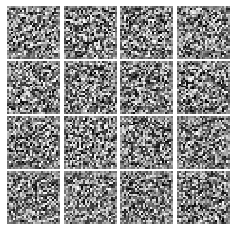

Iter: 0, D: 1.501, G:0.9861
Iter: 50, D: 0.5752, G:3.507
Iter: 100, D: 0.9163, G:1.635
Iter: 150, D: 0.7296, G:1.861
Iter: 200, D: 0.7006, G:1.965


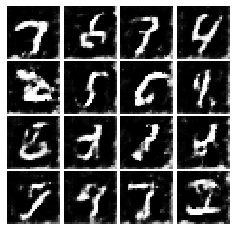

Iter: 250, D: 0.6063, G:2.792
Iter: 300, D: 0.6694, G:1.774
Iter: 350, D: 1.309, G:0.8883
Iter: 400, D: 0.8148, G:2.042
Iter: 450, D: 0.6394, G:1.637


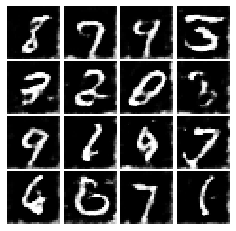

Iter: 500, D: 0.5644, G:2.487
Iter: 550, D: 0.5858, G:2.768
Iter: 600, D: 0.8446, G:1.39
Iter: 650, D: 0.8897, G:2.099
Iter: 700, D: 0.9953, G:3.302


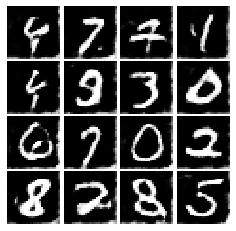

Iter: 750, D: 0.4988, G:1.835
Iter: 800, D: 0.6725, G:1.703
Iter: 850, D: 0.9257, G:2.87
Iter: 900, D: 1.009, G:1.136
Iter: 950, D: 0.8681, G:1.527


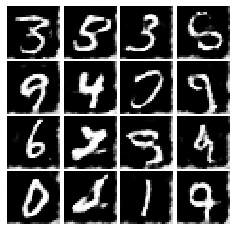

Iter: 1000, D: 0.8938, G:1.848
Iter: 1050, D: 1.118, G:2.463
Iter: 1100, D: 0.814, G:2.063
Iter: 1150, D: 0.8264, G:1.135
Iter: 1200, D: 0.965, G:1.327


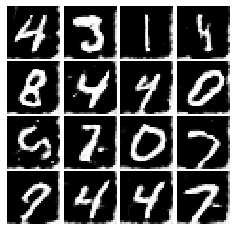

Iter: 1250, D: 0.7393, G:1.889
Iter: 1300, D: 1.034, G:2.742
Iter: 1350, D: 0.8537, G:1.685
Iter: 1400, D: 0.905, G:1.837
Iter: 1450, D: 0.8914, G:0.9558


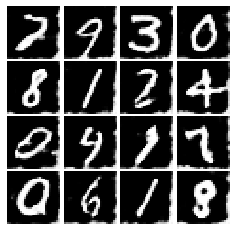

Iter: 1500, D: 0.7004, G:1.965
Iter: 1550, D: 1.132, G:1.119
Iter: 1600, D: 0.8789, G:1.373
Iter: 1650, D: 0.8912, G:1.043
Iter: 1700, D: 0.9939, G:1.23


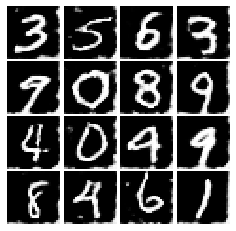

Iter: 1750, D: 0.9008, G:2.293
Iter: 1800, D: 0.7246, G:2.317
Iter: 1850, D: 0.7682, G:1.846
Iter: 1900, D: 0.665, G:1.712
Iter: 1950, D: 1.799, G:4.397


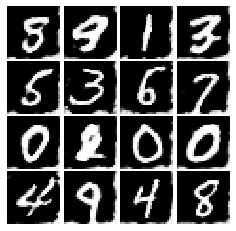

Iter: 2000, D: 0.8067, G:1.699
Iter: 2050, D: 0.6547, G:2.56
Iter: 2100, D: 0.6756, G:1.791
Iter: 2150, D: 0.8381, G:1.206
Iter: 2200, D: 0.9368, G:1.039


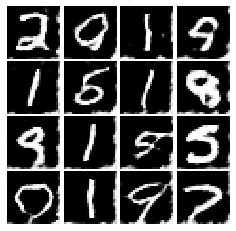

Iter: 2250, D: 0.7489, G:1.8
Iter: 2300, D: 1.158, G:0.4793
Iter: 2350, D: 0.7054, G:2.791
Iter: 2400, D: 0.6306, G:2.679
Iter: 2450, D: 0.5621, G:1.948


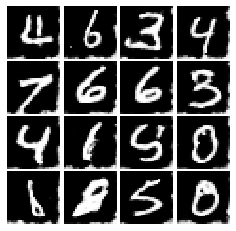

Iter: 2500, D: 0.8121, G:2.004
Iter: 2550, D: 0.6928, G:1.822
Iter: 2600, D: 0.9632, G:3.182
Iter: 2650, D: 0.6866, G:1.958
Iter: 2700, D: 0.6139, G:2.734


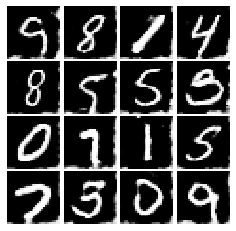

Iter: 2750, D: 0.6372, G:1.614
Iter: 2800, D: 1.305, G:0.312
Iter: 2850, D: 0.5333, G:3.786
Iter: 2900, D: 0.6629, G:2.213
Iter: 2950, D: 0.6801, G:2.015


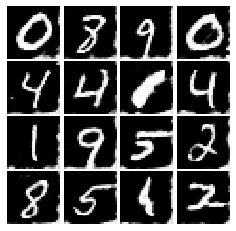

Iter: 3000, D: 0.523, G:2.413
Iter: 3050, D: 0.6804, G:1.983
Iter: 3100, D: 0.4975, G:1.93
Iter: 3150, D: 0.5801, G:3.258
Iter: 3200, D: 0.9903, G:1.472


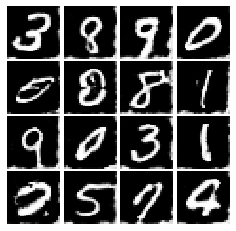

Iter: 3250, D: 0.4874, G:2.376
Iter: 3300, D: 0.4245, G:3.34
Iter: 3350, D: 0.4636, G:2.359
Iter: 3400, D: 0.5885, G:2.846
Iter: 3450, D: 0.4867, G:3.005


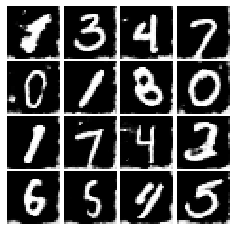

Iter: 3500, D: 0.6219, G:3.52
Iter: 3550, D: 0.4153, G:2.873
Iter: 3600, D: 0.6112, G:2.632
Iter: 3650, D: 0.5778, G:2.442
Iter: 3700, D: 0.5026, G:3.279


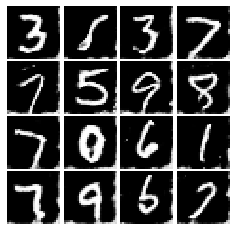

Iter: 3750, D: 0.6241, G:1.441
Iter: 3800, D: 0.6591, G:3.792
Iter: 3850, D: 0.8051, G:3.359
Iter: 3900, D: 0.486, G:2.651
Iter: 3950, D: 0.3893, G:3.358


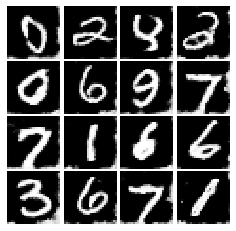

Iter: 4000, D: 0.7058, G:2.637
Iter: 4050, D: 0.5027, G:4.118
Iter: 4100, D: 0.4993, G:1.965
Iter: 4150, D: 0.811, G:2.581
Iter: 4200, D: 0.5045, G:2.006


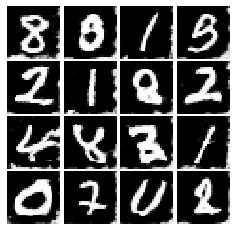

Iter: 4250, D: 0.5818, G:2.131
Iter: 4300, D: 0.4123, G:2.326
Iter: 4350, D: 0.4625, G:3.376
Iter: 4400, D: 0.4755, G:2.983
Iter: 4450, D: 0.6377, G:5.361


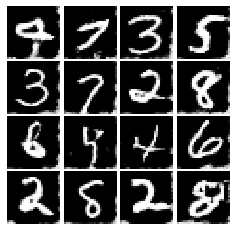

Iter: 4500, D: 0.493, G:2.587
Iter: 4550, D: 0.5805, G:2.816
Iter: 4600, D: 1.029, G:2.154
Iter: 4650, D: 0.3854, G:2.994
Final images


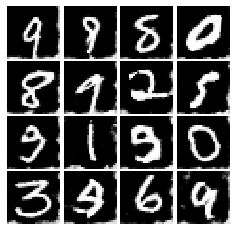

In [10]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, x_train,
              G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,
              batch_size=128, epochs=10)

## WGAN-GP

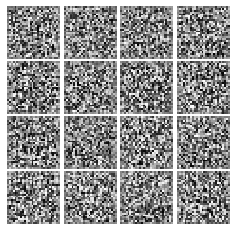


Iter: 0, D: 15.45, G:0.7249
Iter: 50, D: -2.592, G:-4.601
Iter: 100, D: -1.681, G:-0.8597
Iter: 150, D: -1.431, G:1.039
Iter: 200, D: -2.929, G:-0.4105


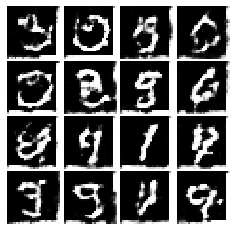


Iter: 250, D: -4.497, G:-8.437
Iter: 300, D: -0.5055, G:5.039
Iter: 350, D: -0.2956, G:2.966
Iter: 400, D: 0.4624, G:0.7913
Iter: 450, D: -0.2259, G:-2.044


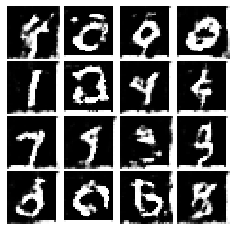


Iter: 500, D: -0.8196, G:0.6131
Iter: 550, D: -0.06523, G:-1.172
Iter: 600, D: -0.5241, G:-2.35
Iter: 650, D: 0.5893, G:-4.761
Iter: 700, D: 0.171, G:0.1104


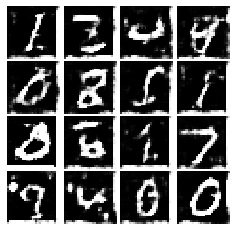


Iter: 750, D: -0.05173, G:-0.2627
Iter: 800, D: -0.2645, G:-3.256
Iter: 850, D: -0.5925, G:-2.087
Iter: 900, D: -0.2935, G:-1.915
Iter: 950, D: -0.6304, G:-1.333


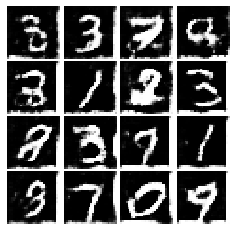


Iter: 1000, D: -0.4053, G:-1.359
Iter: 1050, D: -0.7828, G:-4.782
Iter: 1100, D: -0.8775, G:0.4904
Iter: 1150, D: -0.7293, G:-1.422
Iter: 1200, D: -0.7694, G:0.1865


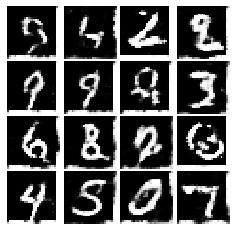


Iter: 1250, D: -1.221, G:-3.109
Iter: 1300, D: -0.753, G:-2.886
Iter: 1350, D: -1.781, G:-9.598
Iter: 1400, D: -1.483, G:-5.22
Iter: 1450, D: -2.069, G:-7.035


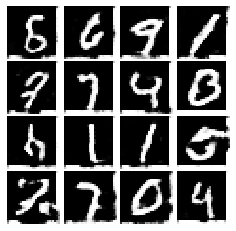


Iter: 1500, D: -1.519, G:-4.344
Iter: 1550, D: -2.242, G:-9.432
Iter: 1600, D: -1.489, G:-5.82
Iter: 1650, D: -0.9743, G:-10.81
Iter: 1700, D: -0.749, G:-7.114


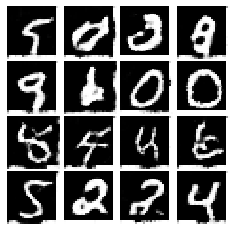


Iter: 1750, D: -2.06, G:-10.78
Iter: 1800, D: -1.377, G:-6.835
Iter: 1850, D: -0.2283, G:-2.518
Iter: 1900, D: -1.927, G:-14.02
Iter: 1950, D: -0.5035, G:-10.21


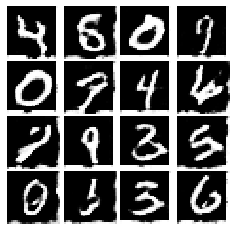


Iter: 2000, D: -0.8661, G:-4.916
Iter: 2050, D: -1.697, G:-3.56
Iter: 2100, D: -2.028, G:-12.51
Iter: 2150, D: -1.086, G:-15.55
Iter: 2200, D: -0.5691, G:-14.32


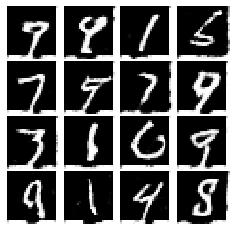


Iter: 2250, D: -0.9442, G:-11.38
Iter: 2300, D: -1.23, G:-11.52
Iter: 2350, D: -1.8, G:-11.78
Iter: 2400, D: -1.503, G:-13.92
Iter: 2450, D: -1.618, G:-15.85


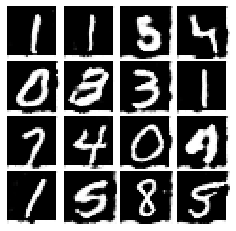


Iter: 2500, D: -2.155, G:-6.032
Iter: 2550, D: 0.04246, G:1.302
Iter: 2600, D: 0.2354, G:-1.004
Iter: 2650, D: -0.1975, G:1.79
Iter: 2700, D: 0.1849, G:-2.242


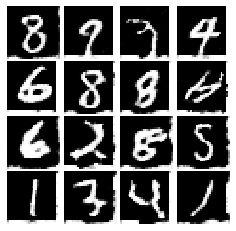


Iter: 2750, D: -0.5891, G:1.691
Iter: 2800, D: -0.04639, G:0.487
Iter: 2850, D: -0.1931, G:0.2349
Iter: 2900, D: -0.1547, G:3.768
Iter: 2950, D: 0.5764, G:-1.466


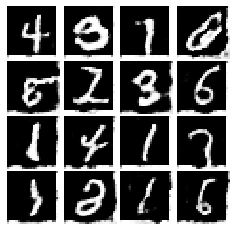


Iter: 3000, D: 0.01305, G:2.936
Iter: 3050, D: -0.11, G:-2.345
Iter: 3100, D: 0.0512, G:2.764
Iter: 3150, D: 0.4581, G:0.4793
Iter: 3200, D: 0.2829, G:-3.541


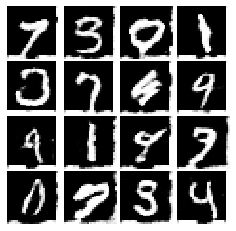


Iter: 3250, D: -0.09363, G:4.098
Iter: 3300, D: 0.04168, G:1.121
Iter: 3350, D: -0.084, G:-0.3573
Iter: 3400, D: -0.09183, G:-1.431
Iter: 3450, D: 0.2388, G:-0.5224


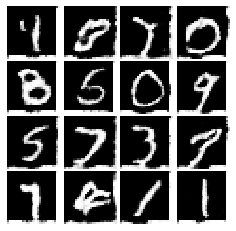


Iter: 3500, D: 0.4381, G:1.611
Iter: 3550, D: -0.2879, G:-1.528
Iter: 3600, D: -0.01769, G:-4.167
Iter: 3650, D: 1.354, G:-1.608
Iter: 3700, D: 0.1352, G:1.164


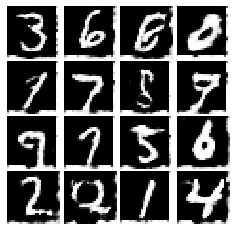


Iter: 3750, D: 0.1965, G:0.5688
Iter: 3800, D: -0.1977, G:1.348
Iter: 3850, D: -0.05237, G:0.8789
Iter: 3900, D: 0.3907, G:1.762
Iter: 3950, D: 0.4528, G:0.682


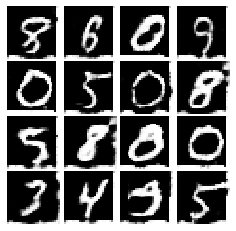


Iter: 4000, D: 0.02371, G:-1.807
Iter: 4050, D: -0.2716, G:1.853
Iter: 4100, D: -0.03642, G:-0.1054
Iter: 4150, D: -0.5264, G:2.027
Iter: 4200, D: 0.299, G:-0.3021


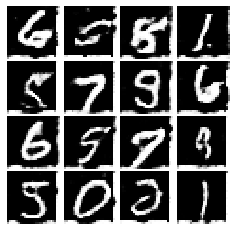


Iter: 4250, D: 0.4343, G:4.055
Final images


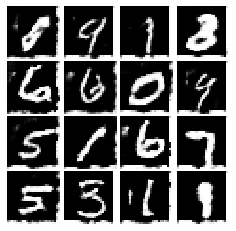

In [0]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=10)

## LSGAN

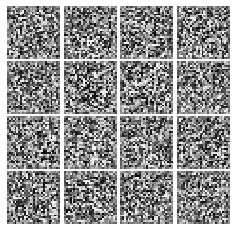


Iter: 0, D: 1.655, G:1.122
Iter: 50, D: 0.07095, G:0.5054
Iter: 100, D: 0.04117, G:0.5261
Iter: 150, D: 0.08556, G:0.4114
Iter: 200, D: 0.1084, G:0.3309


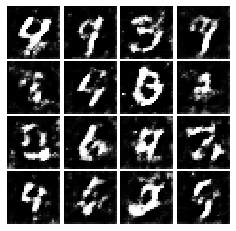


Iter: 250, D: 0.1225, G:0.3294
Iter: 300, D: 0.1039, G:0.3498
Iter: 350, D: 0.1229, G:0.4272
Iter: 400, D: 0.1073, G:0.2658
Iter: 450, D: 0.1379, G:0.343


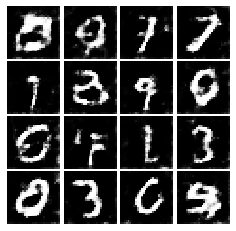


Iter: 500, D: 0.09242, G:0.3043
Iter: 550, D: 0.1205, G:0.3339
Iter: 600, D: 0.1325, G:0.2422
Iter: 650, D: 0.1682, G:0.4469
Iter: 700, D: 0.102, G:0.3543


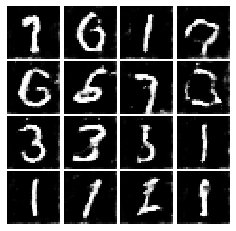


Iter: 750, D: 0.1079, G:0.2382
Iter: 800, D: 0.1145, G:0.2351
Iter: 850, D: 0.1037, G:0.346
Iter: 900, D: 0.1162, G:0.4187
Iter: 950, D: 0.1201, G:0.2785


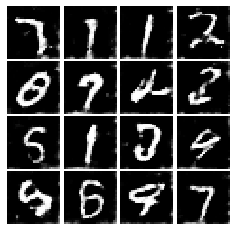


Iter: 1000, D: 0.1048, G:0.3111
Iter: 1050, D: 0.165, G:0.2586
Iter: 1100, D: 0.1383, G:0.286
Iter: 1150, D: 0.1509, G:0.4057
Iter: 1200, D: 0.1137, G:0.424


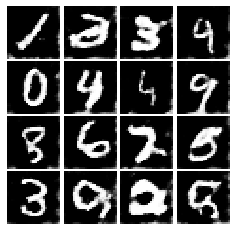


Iter: 1250, D: 0.1234, G:0.2852
Iter: 1300, D: 0.1235, G:0.4051
Iter: 1350, D: 0.1027, G:0.2877
Iter: 1400, D: 0.1366, G:0.3181
Iter: 1450, D: 0.1227, G:0.3055


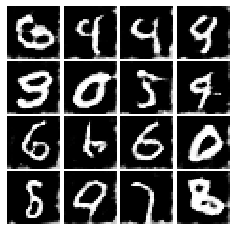


Iter: 1500, D: 0.1584, G:0.2422
Iter: 1550, D: 0.1408, G:0.2713
Iter: 1600, D: 0.1922, G:0.4108
Iter: 1650, D: 0.1584, G:0.2055
Iter: 1700, D: 0.1555, G:0.2834


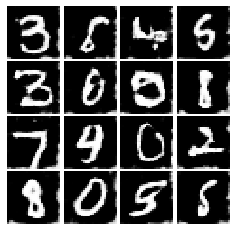


Iter: 1750, D: 0.1202, G:0.4377
Iter: 1800, D: 0.1734, G:0.2299
Iter: 1850, D: 0.1225, G:0.269
Iter: 1900, D: 0.1656, G:0.3718
Iter: 1950, D: 0.1445, G:0.2769


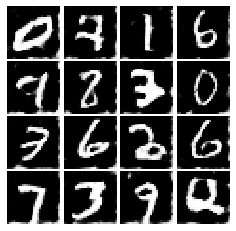


Iter: 2000, D: 0.1453, G:0.2653
Iter: 2050, D: 0.1291, G:0.279
Iter: 2100, D: 0.1535, G:0.2868
Iter: 2150, D: 0.1415, G:0.4899
Iter: 2200, D: 0.1476, G:0.2681


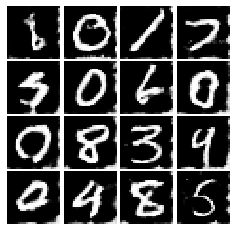


Iter: 2250, D: 0.1153, G:0.2459
Iter: 2300, D: 0.105, G:0.2974
Iter: 2350, D: 0.2015, G:0.07007
Iter: 2400, D: 0.1715, G:0.5023
Iter: 2450, D: 0.1155, G:0.323


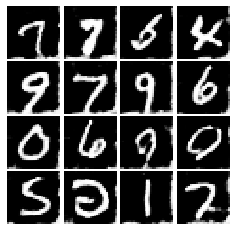


Iter: 2500, D: 0.1186, G:0.389
Iter: 2550, D: 0.1561, G:0.2145
Iter: 2600, D: 0.147, G:0.241
Iter: 2650, D: 0.1525, G:0.6642
Iter: 2700, D: 0.1341, G:0.301


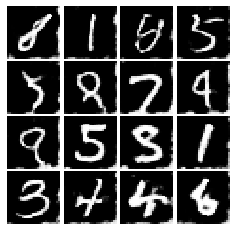


Iter: 2750, D: 0.1169, G:0.2586
Iter: 2800, D: 0.1776, G:0.354
Iter: 2850, D: 0.1033, G:0.3166
Iter: 2900, D: 0.1803, G:0.3227
Iter: 2950, D: 0.1914, G:0.2948


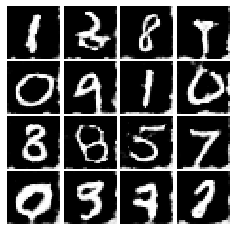


Iter: 3000, D: 0.1001, G:0.4205
Iter: 3050, D: 0.1171, G:0.3979
Iter: 3100, D: 0.1482, G:0.3136
Iter: 3150, D: 0.1215, G:0.386
Iter: 3200, D: 0.1149, G:0.2816


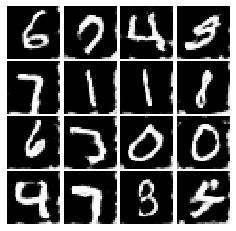


Iter: 3250, D: 0.1194, G:0.4689
Iter: 3300, D: 0.122, G:0.3916
Iter: 3350, D: 0.1075, G:0.2723
Iter: 3400, D: 0.1289, G:0.3663
Iter: 3450, D: 0.2345, G:0.9312


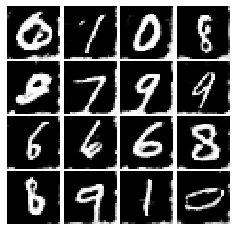


Iter: 3500, D: 0.1249, G:0.2889
Iter: 3550, D: 0.2018, G:0.1499
Iter: 3600, D: 0.1102, G:0.392
Iter: 3650, D: 0.1455, G:0.1776
Iter: 3700, D: 0.1169, G:0.322


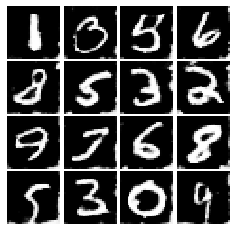


Iter: 3750, D: 0.1181, G:0.5061
Iter: 3800, D: 0.102, G:0.2665
Iter: 3850, D: 0.09813, G:0.3399
Iter: 3900, D: 0.1208, G:0.272
Iter: 3950, D: 0.09888, G:0.3635


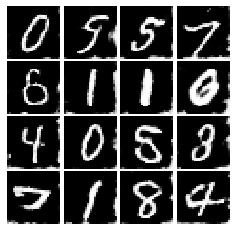


Iter: 4000, D: 0.1158, G:0.3719
Iter: 4050, D: 0.1218, G:0.3797
Iter: 4100, D: 0.1302, G:0.2992
Iter: 4150, D: 0.1121, G:0.2886
Iter: 4200, D: 0.08422, G:0.332


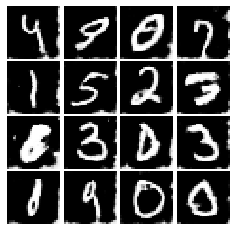


Iter: 4250, D: 0.0926, G:0.4297
Final images


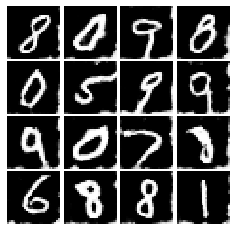

In [0]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=10)